In [1]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from plotting import set_defaults
import pandas as pd
from scipy.optimize import minimize
import random
from sklearn.model_selection import train_test_split
import emcee
import corner
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# -- set the types

kind = "bld"
comp = "bld"
runpca = False
runfan = False
runica = False
getndvi = False

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- load the comparison set
print("getting {0} spectra...".format(comp))
try:
    blds = np.load("../../../gdobler_output/output/blds_right.npy")
except:
    blds = np.array([np.load(i)[:,:,78:].mean(-1).mean(-1) for i in
                     sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs*.npy"\
                                          .format(comp))) if "_avg" not in i])
    blds = blds[good]
    # np.save("../output/blds_right.npy",blds)

getting bld spectra...


In [5]:
# -- normalize spectra
ms, bs = [], []
for ii in range(blds.shape[0]):
    # m, b = np.polyfit(blds[ii,:100],blds[0,:100],1)
    # m, b = np.polyfit(blds[ii],blds[0],1)
    m = blds[0].mean()/blds[ii].mean()
    b = 0.0
    ms.append(m)
    bs.append(b)

ms   = np.array(ms)
bs   = np.array(bs)
norm = blds*ms[:,np.newaxis] + bs[:,np.newaxis]
rat  = norm/norm[0]

In [6]:
# -- get comparison spectra
print("getting {0} spectra...".format(comp))
try:
    vegs = np.load("../../../gdobler_output/output/blds_left.npy")
except:
    vegs = np.array([np.load(i)[:,:,:78].mean(-1).mean(-1) for i in
                     sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs*.npy"\
                                          .format(comp))) if "_avg" not in i])
    vegs = vegs[good]
    # np.save("../../../gdobler_output/output/blds_left.npy",vegs)

getting bld spectra...


In [7]:
# -- normalize spectra
ss, os = [], []
for ii in range(vegs.shape[0]):
    # s, o = np.polyfit(vegs[ii,:100],vegs[0,:100],1)
    # s, o = np.polyfit(vegs[ii],vegs[0],1)
    s = vegs[0].mean()/vegs[ii].mean()
    o = 0.0
    ss.append(s)
    os.append(o)

ss    = np.array(ss)
os    = np.array(os)
vnorm = vegs*ss[:,np.newaxis] + os[:,np.newaxis]
vrat  = vnorm/vnorm[0]

In [8]:
# -- take the ratio of ratios
brat = vrat/rat

In [9]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [10]:
# -- PCA
if runpca:
    print("running PCA...")
    pca = PCA(n_components=6)
    pca.fit(vrat/rat)
    pamps = pca.transform(vrat/rat)

# -- Factor Analysis
if runfan:
    print("running Factor Analysis...")
    fan = FactorAnalysis(n_components=6)
    fan.fit(vrat/rat)
    famps = fan.transform(vrat/rat)

# -- ICA
if runica:
    print("running ICA...")
    ica = FastICA(n_components=6)
    ica.fit(vrat/rat)
    iamps = ica.transform(vrat/rat)

# -- get NDVI
if getndvi:
    print("calculating NDVI...")
    print("  getting sky spectra...")
    flist   = sorted(glob.glob("../../../gdobler_output/output/sky_specs/*.npy"))
    skys    = np.array([np.load(i) for i in flist])[good]
    print("  getting reflectance...")
    ref     = (vegs - vegs.min(1,keepdims=True))/ \
        (skys-skys.min(1,keepdims=True))
    ind_ir  = np.argmin(np.abs(waves-860.))
    ind_vis = np.argmin(np.abs(waves-670.))
    print("  generating NDVI...")
    ndvi    = (ref[:,ind_ir]-ref[:,ind_vis]) / \
        (ref[:,ind_ir]+ref[:,ind_vis])

In [11]:
print(waves[500], waves[-150])
print(waves[430], waves[570])

ind_ir  = np.argmin(np.abs(waves-860.))
ind_vis = np.argmin(np.abs(waves-670.))

749.76 895.9
698.89 801.05


In [12]:
# calculate differential ratios

D_750_1000 = brat[:,500] / brat[:,-1]
D_750_900 = brat[:,500] / brat[:,-150]
D_750_900m1000 = brat[:,500] / (brat[:,-150:].mean(1))
D_700m800_900m1000 = (brat[:,430:570].mean(1)) / (brat[:,-150:].mean(1))
D_700m900_400m700 = (brat[:,424:-150].mean(1)) / (brat[:,:424].mean(1))
D_700m1000_400m700 = (brat[:,424:-1].mean(1)) / (brat[:,:424].mean(1))

In [13]:
# create air quality arrays

aq_opth1  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
aq_pth1 = np.vstack([pm25,temps,humid,np.ones_like(o3)]).T
aq_op1 = np.vstack([o3,pm25,np.ones_like(o3)]).T

## Linear Least Squares - no errors

### (1)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [14]:
ind  = np.arange(len(D_750_1000))
sol1  = np.linalg.lstsq(aq_opth1[ind],D_750_1000[ind], rcond=None)
pred1 = np.dot(aq_opth1[ind],sol1[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol1[1] / (len(D_750_1000) * D_750_1000.var())
print("sol = ", sol1)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-7.40637461e-01,  2.08025765e-04,  6.00040385e-05, -2.97902062e-04,
        1.05367086e+00]), array([1.3524249]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.04550206]


### (2)  D(750) / D(900)   --||vs||--   O3, PM2.5, Temps, Humid

In [15]:
ind  = np.arange(len(D_750_900))
sol2  = np.linalg.lstsq(aq_opth1[ind],D_750_900[ind], rcond=None)
pred2 = np.dot(aq_opth1[ind],sol2[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol2[1] / (len(D_750_900) * D_750_900.var())
print("sol = ", sol2)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-6.24096627e-01,  1.94828950e-04,  8.15609963e-05, -2.25950394e-04,
        1.04208861e+00]), array([1.01086002]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.04048883]


### (3)  D(750) / D(900-1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [16]:
ind  = np.arange(len(D_750_900m1000))
sol3  = np.linalg.lstsq(aq_opth1[ind],D_750_900m1000[ind], rcond=None)
pred3 = np.dot(aq_opth1[ind],sol3[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol3[1] / (len(D_750_900m1000) * D_750_900m1000.var())
print("sol = ", sol3)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-7.05895617e-01,  1.84783781e-04,  6.31809097e-05, -2.74043970e-04,
        1.05220610e+00]), array([1.26124251]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.04385909]


### (4)  D(700-800) / D(900-1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [17]:
ind  = np.arange(len(D_700m800_900m1000))
sol4  = np.linalg.lstsq(aq_opth1[ind],D_700m800_900m1000[ind], rcond=None)
pred4 = np.dot(aq_opth1[ind],sol4[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol4[1] / (len(D_700m800_900m1000) * D_700m800_900m1000.var())
print("sol = ", sol4)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-6.56165823e-01,  1.86188495e-04,  3.10819456e-05, -2.71438648e-04,
        1.05369847e+00]), array([1.01764356]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.04906051]


### (5)  D(700-900) / D(400-700)   --||vs||--   O3, PM2.5, Temps, Humid

In [18]:
ind  = np.arange(len(D_700m900_400m700))
sol5  = np.linalg.lstsq(aq_opth1[ind],D_700m900_400m700[ind], rcond=None)
pred5 = np.dot(aq_opth1[ind],sol5[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol5[1] / (len(D_700m900_400m700) * D_700m900_400m700.var())
print("sol = ", sol5)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([1.89822419e-01, 8.79668309e-05, 2.18112554e-05, 9.89958786e-05,
       9.81790267e-01]), array([0.05217549]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.11118119]


#### Plot all together

### (6)  D(700-1000) / D(400-700)   --||vs||--   O3, PM2.5, Temps, Humid

In [19]:
ind  = np.arange(len(D_700m1000_400m700))
sol6  = np.linalg.lstsq(aq_opth1[ind],D_700m1000_400m700[ind], rcond=None)
pred6 = np.dot(aq_opth1[ind],sol6[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol6[1] / (len(D_700m1000_400m700) * D_700m1000_400m700.var())
print("sol = ", sol6)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([3.39089818e-01, 4.18950834e-05, 1.56304487e-05, 1.59104677e-04,
       9.69475651e-01]), array([0.17167207]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.09151923]


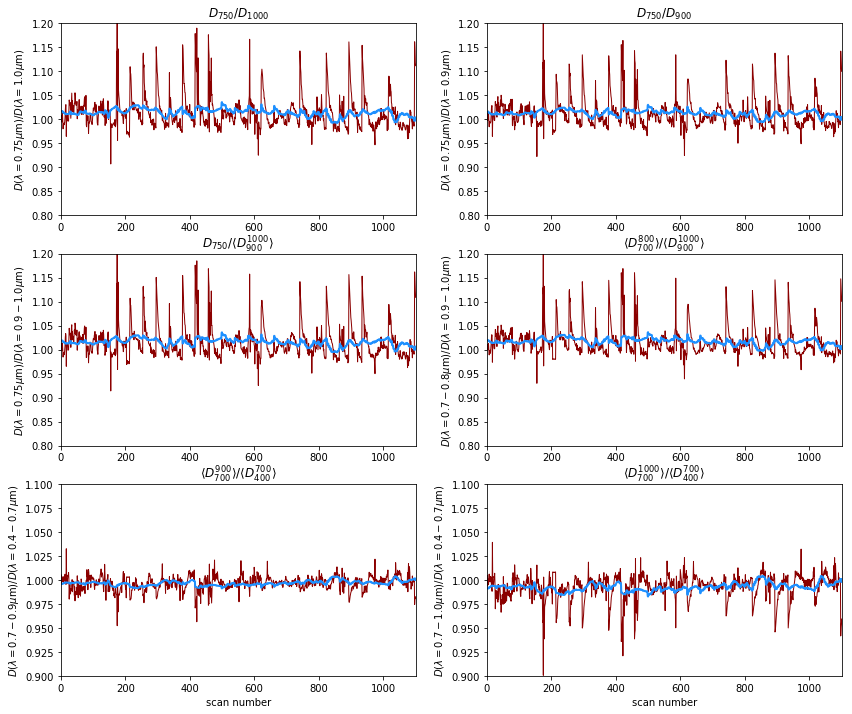

In [20]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

ax1.plot(D_750_1000,color="darkred",lw=1)
ax1.plot(pred1,color="dodgerblue",lw=2)
ax1.set_ylim(0.8,1.2)
ax1.set_xlim(0,pred1.size)
#ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_title(r'$D_{750}/D_{1000}$')

ax2.plot(D_750_900,color="darkred",lw=1)
ax2.plot(pred2,color="dodgerblue",lw=2)
ax2.set_ylim(0.8,1.2)
ax2.set_xlim(0,pred2.size)
#ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9\mu$m$)$')
ax2.set_title(r'$D_{750}/D_{900}$')

ax3.plot(D_750_900m1000,color="darkred",lw=1)
ax3.plot(pred3,color="dodgerblue",lw=2)
ax3.set_ylim(0.8,1.2)
ax3.set_xlim(0,pred3.size)
#ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax3.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax3.set_title(r'$D_{750}/\langle D_{900}^{1000} \rangle$')

ax4.plot(D_700m800_900m1000,color="darkred",lw=1)
ax4.plot(pred4,color="dodgerblue",lw=2)
ax4.set_ylim(0.8,1.2)
ax4.set_xlim(0,pred4.size)
#ax4.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax4.set_ylabel(r'$D(\lambda=0.7-0.8\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax4.set_title(r'$\langle D_{700}^{800} \rangle/\langle D_{900}^{1000} \rangle$')

ax5.plot(D_700m900_400m700,color="darkred",lw=1)
ax5.plot(pred5,color="dodgerblue",lw=2)
ax5.set_ylim(0.9,1.1)
ax5.set_xlim(0,pred5.size)
ax5.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax5.set_ylabel(r'$D(\lambda=0.7-0.9\mu$m$)/D(\lambda=0.4-0.7\mu$m$)$')
ax5.set_title(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')

ax6.plot(D_700m1000_400m700,color="darkred",lw=1)
ax6.plot(pred6,color="dodgerblue",lw=2)
ax6.set_ylim(0.9,1.1)
ax6.set_xlim(0,pred6.size)
ax6.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax6.set_ylabel(r'$D(\lambda=0.7-1.0\mu$m$)/D(\lambda=0.4-0.7\mu$m$)$')
ax6.set_title(r'$\langle D_{700}^{1000} \rangle/\langle D_{400}^{700} \rangle$')

plt.show()

### Using Vegetation Indices

In [21]:
ind_ir  = np.argmin(np.abs(waves-860.))
ind_r   = np.argmin(np.abs(waves-670.))
#ind_g1   = np.argmin(np.abs(waves-531.))
#ind_g2   = np.argmin(np.abs(waves-570.))
#ind_b   = np.argmin(np.abs(waves-455.))

In [22]:
# Simple Ratio 
# SR = NIR / R
D_SR = (brat[:,ind_ir] / brat[:,ind_r])

# Normalized Difference Vegetation Index
# NDVI = (NIR - R) / (NIR + R)
D_NDVI = (brat[:,ind_ir] - brat[:,ind_r]) / (brat[:,ind_ir] + brat[:,ind_r])

# Feedback-based, Soil and Atmosphere Resistant Vegetation Index
# SARVI2 = 2.5 * (NIR - Red) / (1 + NIR + (6 * Red) - (7.5 - Blue))
#D_SARVI2 = 2.5 * (brat[:,ind_ir] - brat[:,ind_vis]) / (1 + brat[:,ind_ir] + (6 * brat[:,ind_r]) - (7.5 * brat[:,ind_b]))

# Photochemical Reflectance Index
# PRI = (R531 - R570) / (R531 + R570)
#D_PRI = (brat[:,ind_g1] - brat[:,ind_g2]) / (brat[:,ind_g1] + brat[:,ind_g2])

### (1)  D(SR)   --||vs||--   O3, PM2.5, Temps, Humid
#### D(SR) = D(NIR) / D(Red)
#### NIR = 860nm, Red = 670nm

In [23]:
ind  = np.arange(len(D_SR))
solSR  = np.linalg.lstsq(aq_opth1[ind],D_SR[ind], rcond=None)
predSR = np.dot(aq_opth1[ind],solSR[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solSR[1] / (len(D_SR) * D_SR.var())
print("sol = ", solSR)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 6.79942970e-01, -1.36256991e-04, -6.60477433e-05,  2.82641393e-04,
        9.45922004e-01]), array([0.73977666]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.06911977]


### (2)  D(NDVI)   --||vs||--   O3, PM2.5, Temps, Humid
#### D(NDVI) = (D(NIR) - D(Red)) / (D(NIR) + D(Red))
#### NIR = 860nm, Red = 670nm

In [24]:
ind  = np.arange(len(D_NDVI))
solNDVI  = np.linalg.lstsq(aq_opth1[ind],D_NDVI[ind], rcond=None)
predNDVI = np.dot(aq_opth1[ind],solNDVI[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solNDVI[1] / (len(D_NDVI) * D_NDVI.var())
print("sol = ", solNDVI)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 3.53975165e-01, -7.32470009e-05, -3.47358592e-05,  1.47118264e-04,
       -2.80142241e-02]), array([0.20311509]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.06815549]


### (3)  D(SARVI2)   --||vs||--   O3, PM2.5, Temps, Humid
#### D(SARVI2) = 2.5 * (D(NIR) - D(Red)) / (1 + D(NIR) + (6 * D(Red)) - (7.5 - D(Blue)))
#### NIR = 860nm, Red = 670nm, Blue = 455nm

In [ ]:
ind  = np.arange(len(D_SARVI2))
solSARVI2  = np.linalg.lstsq(aq_opth1[ind],D_SARVI2[ind], rcond=None)
predSARVI2 = np.dot(aq_opth1[ind],solSARVI2[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solSARVI2[1] / (len(D_SARVI2) * D_SARVI2.var())
print("sol = ", solSARVI2)
#print("rsq = ", rsq)
print("r2  = ", r2)

### (4)  D(PRI)   --||vs||--   O3, PM2.5, Temps, Humid
#### D(PRI) = (D(531) - D(570)) / (D(531) + D(570))

In [ ]:
ind  = np.arange(len(D_PRI))
solPRI  = np.linalg.lstsq(aq_opth1[ind],D_PRI[ind], rcond=None)
predPRI = np.dot(aq_opth1[ind],solPRI[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solPRI[1] / (len(D_PRI) * D_PRI.var())
print("sol = ", solPRI)
#print("rsq = ", rsq)
print("r2  = ", r2)

#### Plot all indices together

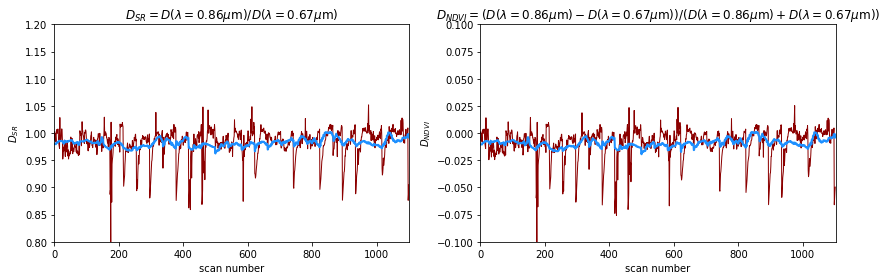

In [26]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14,4))

ax1.plot(D_SR,color="darkred",lw=1)
ax1.plot(predSR,color="dodgerblue",lw=2)
ax1.set_ylim(0.8,1.2)
ax1.set_xlim(0,predSR.size)
ax1.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax1.set_ylabel(r'$D_{SR}$')
ax1.set_title(r'$D_{SR} = D(\lambda=0.86\mu$m$)/D(\lambda=0.67\mu$m$)$')

ax2.plot(D_NDVI,color="darkred",lw=1)
ax2.plot(predNDVI,color="dodgerblue",lw=2)
ax2.set_ylim(-0.1,0.1)
ax2.set_xlim(0,predNDVI.size)
ax2.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax2.set_ylabel(r'$D_{NDVI}$')
ax2.set_title(r'$D_{NDVI} = (D(\lambda=0.86\mu$m$) - D(\lambda=0.67\mu$m$)) / (D(\lambda=0.86\mu$m$) + D(\lambda=0.67\mu$m$))$')

#ax3.plot(D_SARVI2,color="darkred",lw=1)
#ax3.plot(predSARVI2,color="dodgerblue",lw=2)
##ax3.set_ylim(-100,100)
#ax3.set_xlim(0,predSARVI2.size)
#ax3.set_xlabel("scan number")
##ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
#ax3.set_ylabel(r'$D(SARVI2)$')
#ax3.set_title(r'$D_{SARVI2}$')

#ax4.plot(D_PRI,color="darkred",lw=1)
#ax4.plot(predPRI,color="dodgerblue",lw=2)
#ax4.set_ylim(-0.03,0.02)
#ax4.set_xlim(0,predPRI.size)
#ax4.set_xlabel("scan number")
##ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
#ax4.set_ylabel(r'$D(PRI)$')
#ax4.set_title(r'$D_{PRI}$')

plt.show()

## Maximum Likelihood Estimation with NDVI

$NDVI = m_{O_3} * O_3 + m_{PM2.5} * PM2.5 + m_{temp} * temp + m_{humid} * humid + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

NDVI observed = true NDVI + random.normal(0, $\epsilon$, number_of_observations)

In [27]:
# -- obtaining uncertainty for brightness
#brightness = brat[:,500]/brat[:,-1]
brightness = D_NDVI
diff = brightness[1:] - brightness[:-1]
berr = diff.std()/np.sqrt(2.0)
print("error in NDVI = ", berr)

error in NDVI =  0.007586733147134955


In [28]:
# -- obtaining uncertainty for air quality
templates  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

errors in air qaulity =  [2.50960907e-03 7.69473073e-01 1.30383320e+00 2.97720678e+00
 0.00000000e+00]


In [29]:
brightness_err = np.full(brightness.shape, berr)
o3err = np.full(brightness.shape, air_err[0])
pm25err = np.full(brightness.shape, air_err[1])
temperr = np.full(brightness.shape, air_err[2])
humiderr = np.full(brightness.shape, air_err[3])
alphaerr = np.full(brightness.shape, air_err[4])
terr = np.vstack([o3err,pm25err,temperr,humiderr,alphaerr]).T

In [30]:
def log_prior(theta):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, temps, humid, y):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, temps, humid, y)

In [31]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(solNDVI[0], berr)
result = minimize(nll, initial, args=(templates[:,0], templates[:,1], templates[:,2], 
                                    templates[:,3], brightness))
beta_o3_ml, beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("m_o3    =  {0:.5f}".format(beta_o3_ml))
print("m_pm25  = {0:.5f}".format(beta_pm25_ml))
print("m_temps = {0:.5f}".format(beta_temps_ml))
print("m_humid =  {0:.5f}".format(beta_humid_ml))
print("b       = {0:.5f}".format(alpha_ml))
print("e       =  {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
m_o3    =  0.35435
m_pm25  = -0.00007
m_temps = -0.00004
m_humid =  0.00015
b       = -0.02796
e       =  0.01358


#### split sample into 80% training and 20% testing

In [32]:
from sklearn.model_selection import train_test_split

aq_tr, aq_te, ndvi_tr, ndvi_te = train_test_split(templates, brightness, test_size=0.2, random_state=314)

In [33]:
print("total # of instances: ", len(brightness))
print("# training instances: ", len(ndvi_tr))
print("# testing instances : ", len(ndvi_te))
print("# features (incl. 1): ", aq_tr.shape[1])

total # of instances:  1102
# training instances:  881
# testing instances :  221
# features (incl. 1):  5


## MCMC

$brightness = m_{O_3} * O_3 + m_{PM2.5} * PM2.5 + m_{temp} * temp + m_{humid} * humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [34]:
nwalkers, ndim = 50, 6
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [35]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
                                                              aq_tr[:,1],
                                                              aq_tr[:,2],
                                                              aq_tr[:,3],
                                                              ndvi_tr))
pos, prob, state = sampler.run_mcmc(p0, 5000)

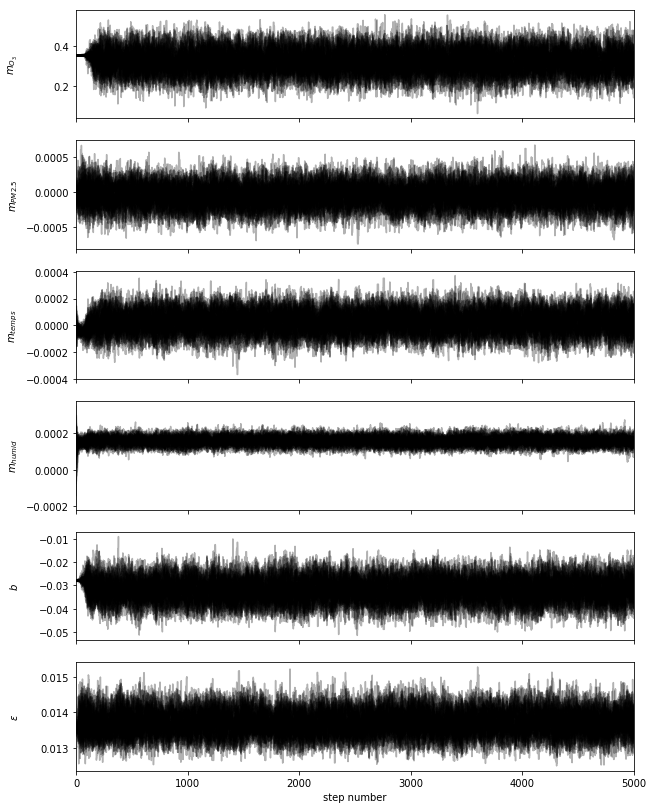

In [36]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$m_{O_3}$', r'$m_{PM2.5}$', r'$m_{temps}$', r'$m_{humid}$', r'$b$', r'$\epsilon$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [37]:
tau = sampler.get_autocorr_time()
print(tau)

[61.81855028 65.33549481 60.57605589 60.98483567 59.00268466 55.60879749]


In [38]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)
print(flat_samples.shape)

(8000, 6)


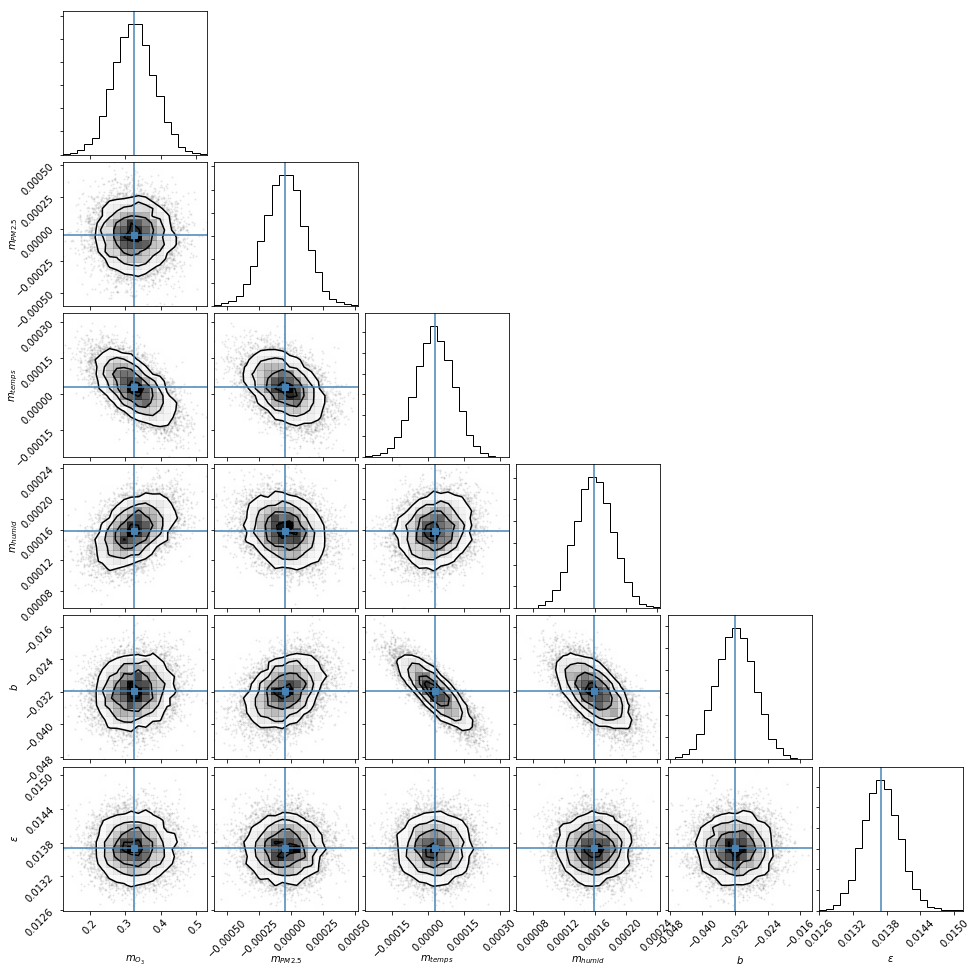

In [39]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [40]:
from IPython.display import display, Math

labels = ["m_{O_3}", "m_{PM2.5}", "m_{temps}", "m_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

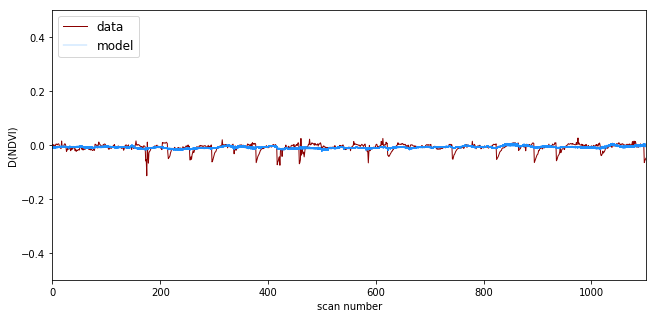

In [41]:
fig, ax = plt.subplots(figsize=[10,5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = plt.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,predNDVI.size)
ax.set_xlabel("scan number")
ax.set_ylabel('D(NDVI)')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [42]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(6)
err_vals = np.zeros(6)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[ 3.24452179e-01 -4.74114477e-05  2.71180323e-05  1.58746499e-04
 -3.18892108e-02  1.37015002e-02]
[5.64748791e-02 1.54983944e-04 7.83042924e-05 2.45111397e-05
 4.75033404e-03 3.26892766e-04]


In [43]:
# calculate prediction and uncertainty
pred_tr = np.dot(aq_tr, mvals[:5])
pred_te = np.dot(aq_te, mvals[:5])
pred_tr_err = np.zeros(pred_tr.shape)
pred_te_err = np.zeros(pred_te.shape)

def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

for i in range(aq_tr.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_tr[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_tr[i,1], air_err[1])
    mt_err = err_mult(mvals[2], err_vals[2], aq_tr[i,2], air_err[2])
    mh_err = err_mult(mvals[3], err_vals[3], aq_tr[i,3], air_err[3])
    pred_tr_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[4]]))

for i in range(aq_te.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_te[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_te[i,1], air_err[1])
    mt_err = err_mult(mvals[2], err_vals[2], aq_te[i,2], air_err[2])
    mh_err = err_mult(mvals[3], err_vals[3], aq_te[i,3], air_err[3])
    pred_te_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[4]]))

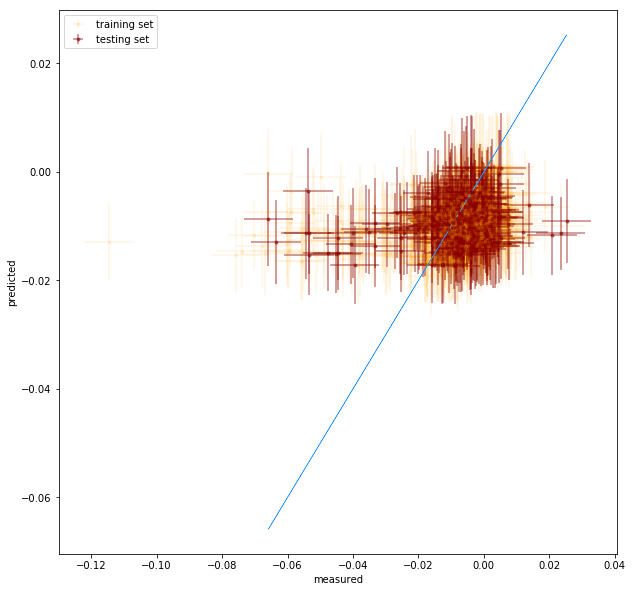

In [44]:
fig = plt.subplots(figsize=[10, 10])
linetr = plt.errorbar(ndvi_tr, pred_tr, xerr=np.full(ndvi_tr.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="orange", alpha=0.1)
linete = plt.errorbar(ndvi_te, pred_te, xerr=np.full(ndvi_te.shape, berr), 
                      yerr=pred_te_err, fmt='.', color="darkred", alpha=0.5)
linlin, = plt.plot(ndvi_te, ndvi_te, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [45]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

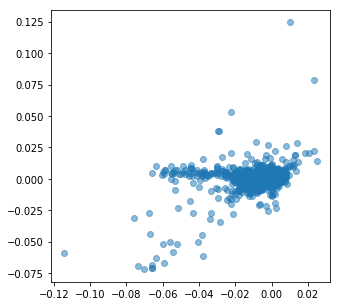

In [46]:
# -- obtaining uncertainties for measured

fig = plt.subplots(figsize=[5,5])
diff = brightness[1:] - brightness[:-1]
plt.plot(brightness[1:], diff, 'o', alpha=0.5)
plt.show()

In [47]:
berr = diff.std()/np.sqrt(2.0)
print("error in NDVI = ", berr)

error in NDVI =  0.007586733147134955


In [48]:
chisq_tr_opth = redchisqg(ndvi_tr, pred_tr, deg=ndim-1, sd=np.full(ndvi_tr.shape, berr))
chisq_te_opth = redchisqg(ndvi_te, pred_te, deg=ndim-1, sd=np.full(ndvi_te.shape, berr))

print("Training chi^2/dof = {0:.3f}".format(chisq_tr_opth))
print("Testing chi^2/dof  = {0:.3f}".format(chisq_te_opth))

Training chi^2/dof = 3.254
Testing chi^2/dof  = 3.163


# Without O3

In [49]:
aq_pth1 = np.vstack([pm25,temps,humid,np.ones_like(o3)]).T

In [50]:
ind  = np.arange(len(D_NDVI))
solNDVI  = np.linalg.lstsq(aq_pth1[ind],D_NDVI[ind], rcond=None)
predNDVI = np.dot(aq_pth1[ind],solNDVI[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solNDVI[1] / (len(D_NDVI) * D_NDVI.var())
print("sol = ", solNDVI)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-3.05742003e-05,  2.60419636e-04,  8.21378994e-05, -3.15168086e-02]), array([0.21211348]), 4, array([2958.97846333,  806.15043572,  103.97132823,    3.26923425]))
r2  =  [0.02687299]


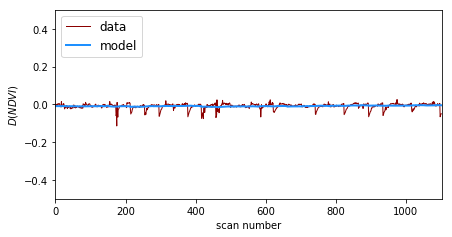

In [51]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_NDVI,color="darkred",lw=1)
linp, = ax.plot(predNDVI,color="dodgerblue",lw=2)
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,predNDVI.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(NDVI)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

## Maximum Likelihood Estimation with NDVI

$NDVI = m_{PM2.5} * PM2.5 + m_{temp} * temp + m_{humid} * humid + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

NDVI observed = true NDVI + random.normal(0, $\epsilon$, number_of_observations)

In [52]:
def log_prior(theta):
    beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, pm25, temps, humid, y):
    beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, pm25, temps, humid, y)

In [53]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(solNDVI[0], berr)
result = minimize(nll, initial, args=(aq_pth1[:,0], aq_pth1[:,1], aq_pth1[:,2], brightness))
beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("m_pm25  = {0:.5f}".format(beta_pm25_ml))
print("m_temps =  {0:.5f}".format(beta_temps_ml))
print("m_humid =  {0:.5f}".format(beta_humid_ml))
print("b       = {0:.5f}".format(alpha_ml))
print("e       =  {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
m_pm25  = -0.00003
m_temps =  0.00026
m_humid =  0.00008
b       = -0.03146
e       =  0.01387


#### split sample into 80% training and 20% testing

In [54]:
from sklearn.model_selection import train_test_split

aq_tr, aq_te, ndvi_tr, ndvi_te = train_test_split(aq_pth1, brightness, test_size=0.2, random_state=314)

In [55]:
print("total # of instances: ", len(brightness))
print("# training instances: ", len(ndvi_tr))
print("# testing instances : ", len(ndvi_te))
print("# features (incl. 1): ", aq_tr.shape[1])

total # of instances:  1102
# training instances:  881
# testing instances :  221
# features (incl. 1):  4


## MCMC

$brightness = m_{PM2.5} * PM2.5 + m_{temp} * temp + m_{humid} * humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [56]:
nwalkers, ndim = 50, 5
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [57]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
                                                              aq_tr[:,1],
                                                              aq_tr[:,2],
                                                              ndvi_tr))
pos, prob, state = sampler.run_mcmc(p0, 5000)

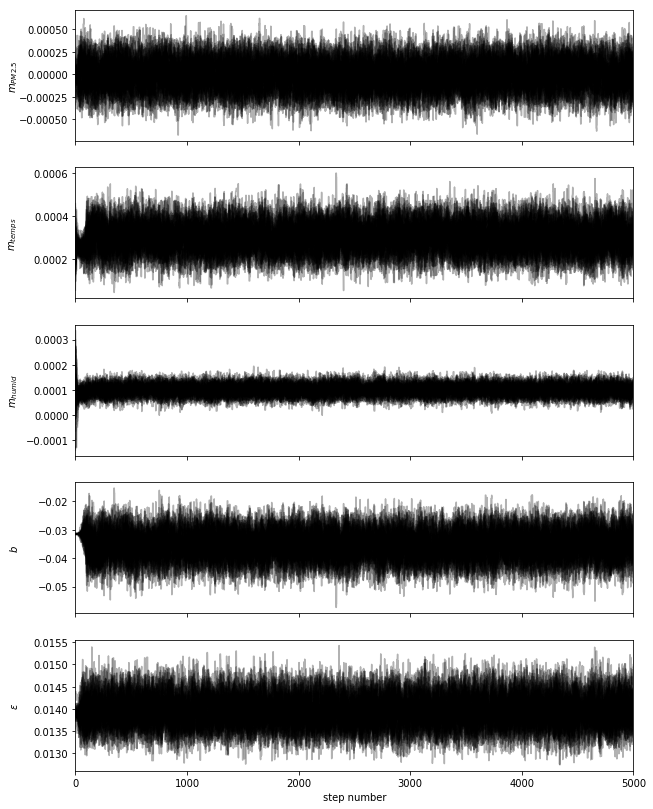

In [58]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$m_{PM2.5}$', r'$m_{temps}$', r'$m_{humid}$', r'$b$', r'$\epsilon$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [59]:
tau = sampler.get_autocorr_time()
print(tau)

[50.54010391 50.80067196 55.83876295 51.95907911 51.46261063]


In [60]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=150, thin=25, flat=True)
print(flat_samples.shape)

(9700, 5)


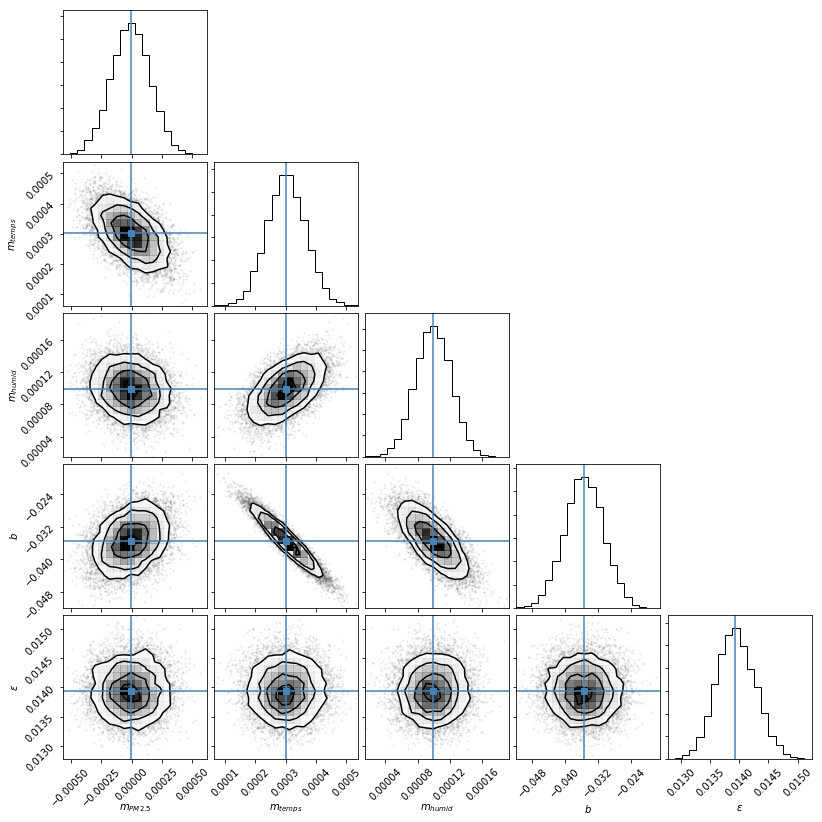

In [61]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [62]:
from IPython.display import display, Math

labels = ["m_{PM2.5}", "m_{temps}", "m_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

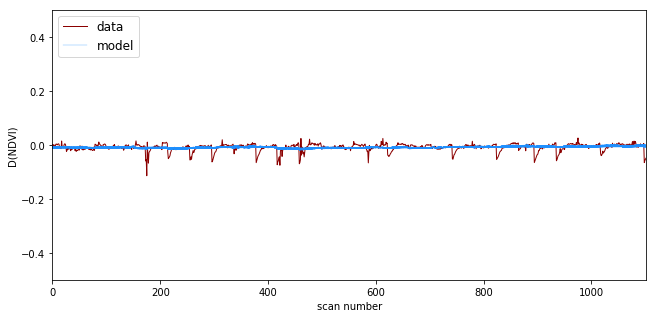

In [63]:
fig, ax = plt.subplots(figsize=[10,5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = plt.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(aq_pth1, sample[:4]), color="dodgerblue", lw=0.3)
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,predNDVI.size)
ax.set_xlabel("scan number")
ax.set_ylabel('D(NDVI)')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [64]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(5)
err_vals = np.zeros(5)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[-6.60527574e-06  3.01240685e-04  9.89001249e-05 -3.54353887e-02
  1.39330328e-02]
[1.58545544e-04 6.31056211e-05 2.19363429e-05 4.70632306e-03
 3.37560552e-04]


In [65]:
# calculate prediction and uncertainty
pred_tr = np.dot(aq_tr, mvals[:4])
pred_te = np.dot(aq_te, mvals[:4])
pred_tr_err = np.zeros(pred_tr.shape)
pred_te_err = np.zeros(pred_te.shape)

def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

for i in range(aq_tr.shape[0]):
    mp_err = err_mult(mvals[1], err_vals[1], aq_tr[i,1], air_err[0])
    mt_err = err_mult(mvals[2], err_vals[2], aq_tr[i,2], air_err[1])
    mh_err = err_mult(mvals[3], err_vals[3], aq_tr[i,3], air_err[2])
    pred_tr_err[i] = np.linalg.norm(np.array([mp_err, mt_err, mh_err, err_vals[3]]))

for i in range(aq_te.shape[0]):
    mp_err = err_mult(mvals[0], err_vals[0], aq_te[i,0], air_err[0])
    mt_err = err_mult(mvals[1], err_vals[1], aq_te[i,1], air_err[1])
    mh_err = err_mult(mvals[2], err_vals[2], aq_te[i,2], air_err[2])
    pred_te_err[i] = np.linalg.norm(np.array([mp_err, mt_err, mh_err, err_vals[3]]))

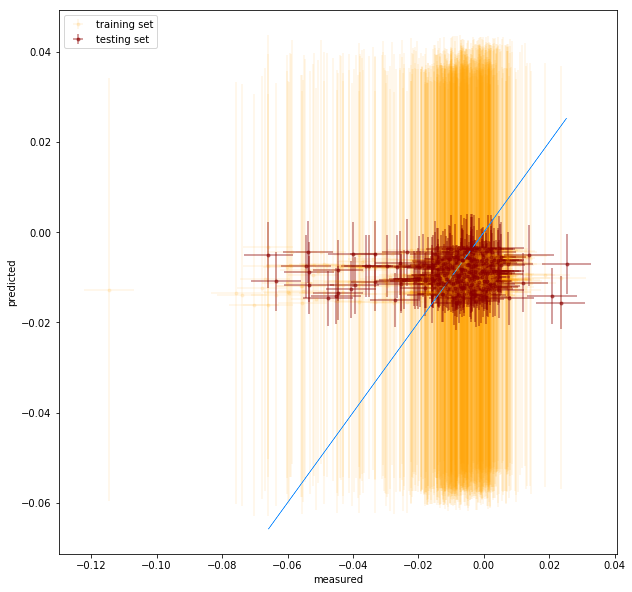

In [66]:
fig = plt.subplots(figsize=[10, 10])
linetr = plt.errorbar(ndvi_tr, pred_tr, xerr=np.full(ndvi_tr.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="orange", alpha=0.1)
linete = plt.errorbar(ndvi_te, pred_te, xerr=np.full(ndvi_te.shape, berr), 
                      yerr=pred_te_err, fmt='.', color="darkred", alpha=0.5)
linlin, = plt.plot(ndvi_te, ndvi_te, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [67]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

In [68]:
chisq_tr_pth = redchisqg(ndvi_tr, pred_tr, deg=ndim-1, sd=np.full(ndvi_tr.shape, berr))
chisq_te_pth = redchisqg(ndvi_te, pred_te, deg=ndim-1, sd=np.full(ndvi_te.shape, berr))

print("Training chi^2/dof = {0:.3f}".format(chisq_tr_pth))
print("Testing chi^2/dof  = {0:.3f}".format(chisq_te_pth))

Training chi^2/dof = 3.372
Testing chi^2/dof  = 3.373


In [69]:
print("Delta chi^2/dof (with O3 - without O3)")
print("Training = {0:.3f}".format(chisq_tr_opth - chisq_tr_pth))
print("Testing  = {0:.3f}".format(chisq_te_opth - chisq_te_pth))

Delta chi^2/dof (with O3 - without O3)
Training = -0.118
Testing  = -0.209


# Without Temps and Humidity

In [70]:
aq_op1 = np.vstack([o3,pm25,np.ones_like(o3)]).T

In [71]:
ind  = np.arange(len(D_NDVI))
solNDVI  = np.linalg.lstsq(aq_op1[ind],D_NDVI[ind], rcond=None)
predNDVI = np.dot(aq_op1[ind],solNDVI[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solNDVI[1] / (len(D_NDVI) * D_NDVI.var())
print("sol = ", solNDVI)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.54966645e-01,  2.55177616e-05, -1.53760902e-02]), array([0.21210606]), 3, array([238.98473575,  16.4096876 ,   0.446111  ]))
r2  =  [0.026907]


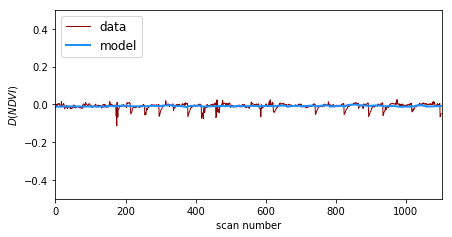

In [72]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_NDVI,color="darkred",lw=1)
linp, = ax.plot(predNDVI,color="dodgerblue",lw=2)
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,predNDVI.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(NDVI)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

## Maximum Likelihood Estimation with NDVI

$NDVI = m_{O_3} * O_3 + m_{PM2.5} * PM2.5 + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

NDVI observed = true NDVI + random.normal(0, $\epsilon$, number_of_observations)

In [73]:
def log_prior(theta):
    beta_o3, beta_pm25, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, y):
    beta_o3, beta_pm25, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, y)

In [74]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(solNDVI[0], berr)
result = minimize(nll, initial, args=(aq_op1[:,0], aq_op1[:,1], brightness))
beta_o3_ml, beta_pm25_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("m_o3   =  {0:.5f}".format(beta_o3_ml))
print("m_pm25 =  {0:.5f}".format(beta_pm25_ml))
print("b      = {0:.5f}".format(alpha_ml))
print("e      =  {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
m_o3   =  0.15497
m_pm25 =  0.00003
b      = -0.01538
e      =  0.01387


#### split sample into 80% training and 20% testing

In [75]:
from sklearn.model_selection import train_test_split

aq_tr, aq_te, ndvi_tr, ndvi_te = train_test_split(aq_op1, brightness, test_size=0.2, random_state=314)

In [76]:
print("total # of instances: ", len(brightness))
print("# training instances: ", len(ndvi_tr))
print("# testing instances : ", len(ndvi_te))
print("# features (incl. 1): ", aq_tr.shape[1])

total # of instances:  1102
# training instances:  881
# testing instances :  221
# features (incl. 1):  3


## MCMC

$brightness = m_{O_3} * O_3 + m_{PM2.5} * PM2.5 + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [77]:
nwalkers, ndim = 50, 4
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [78]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
                                                              aq_tr[:,1],
                                                              ndvi_tr))
pos, prob, state = sampler.run_mcmc(p0, 5000)

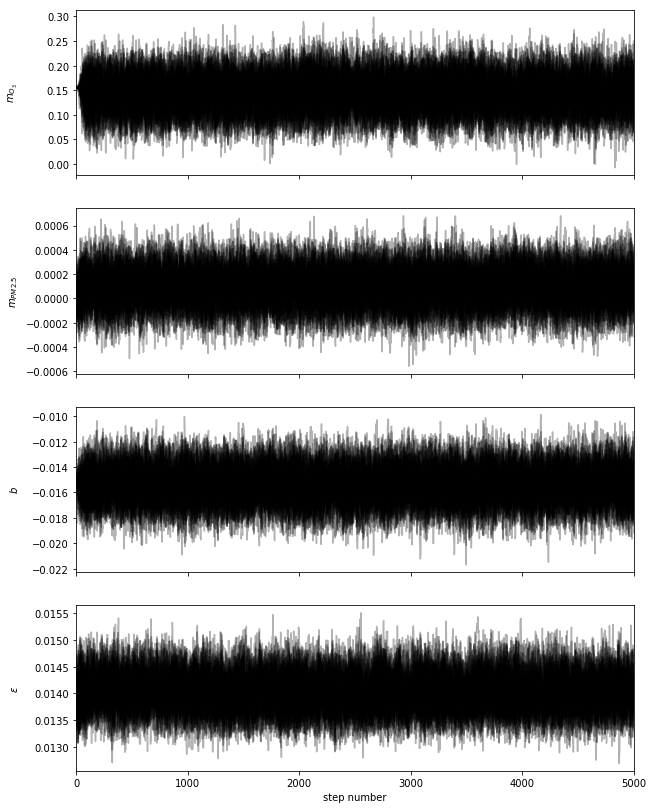

In [79]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$m_{O_3}$', r'$m_{PM2.5}$', r'$b$', r'$\epsilon$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [80]:
tau = sampler.get_autocorr_time()
print(tau)

[46.39497105 44.97285971 44.02413682 43.27760025]


In [81]:
# -- discard initial 120 steps (~3 x tau)
# -- thin by 20 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=120, thin=20, flat=True)
print(flat_samples.shape)

(12200, 4)


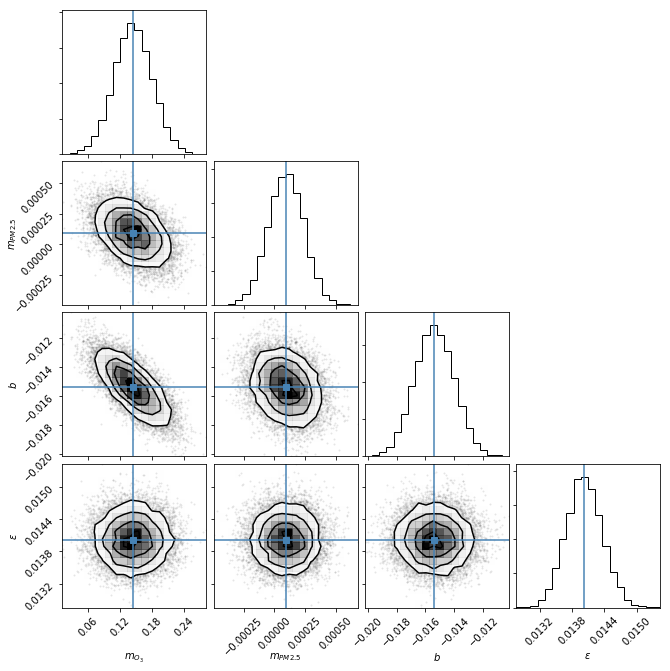

In [82]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [83]:
from IPython.display import display, Math

labels = ["m_{O_3}", "m_{PM2.5}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

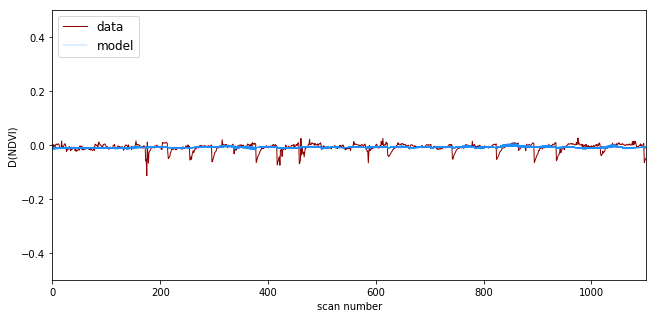

In [84]:
fig, ax = plt.subplots(figsize=[10,5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = plt.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(aq_op1, sample[:3]), color="dodgerblue", lw=0.3)
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,predNDVI.size)
ax.set_xlabel("scan number")
ax.set_ylabel('D(NDVI)')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [85]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(4)
err_vals = np.zeros(4)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[ 1.43730214e-01  9.51083959e-05 -1.53970916e-02  1.40206376e-02]
[0.03527301 0.00014423 0.00136396 0.00033476]


In [86]:
# calculate prediction and uncertainty
pred_tr = np.dot(aq_tr, mvals[:3])
pred_te = np.dot(aq_te, mvals[:3])
pred_tr_err = np.zeros(pred_tr.shape)
pred_te_err = np.zeros(pred_te.shape)

def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

for i in range(aq_tr.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_tr[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_tr[i,1], air_err[1])
    pred_tr_err[i] = np.linalg.norm(np.array([mO_err, mp_err, err_vals[2]]))

for i in range(aq_te.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_te[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_te[i,1], air_err[1])
    pred_te_err[i] = np.linalg.norm(np.array([mO_err, mp_err, err_vals[2]]))

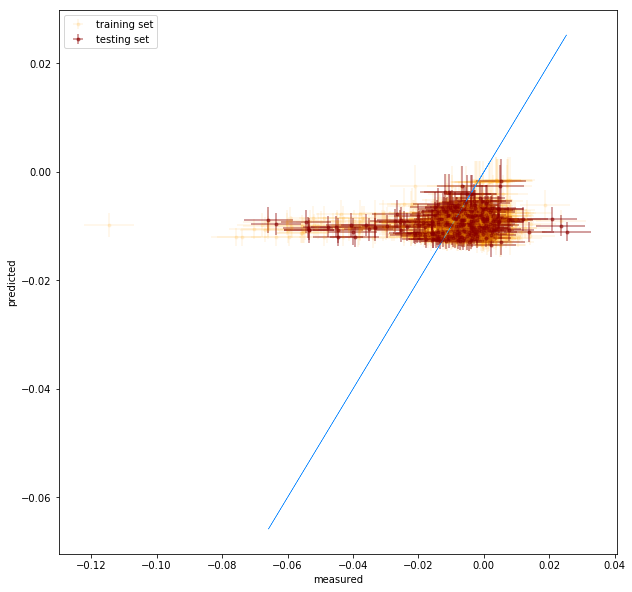

In [87]:
fig = plt.subplots(figsize=[10, 10])
linetr = plt.errorbar(ndvi_tr, pred_tr, xerr=np.full(ndvi_tr.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="orange", alpha=0.1)
linete = plt.errorbar(ndvi_te, pred_te, xerr=np.full(ndvi_te.shape, berr), 
                      yerr=pred_te_err, fmt='.', color="darkred", alpha=0.5)
linlin, = plt.plot(ndvi_te, ndvi_te, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [88]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

In [89]:
chisq_tr_op = redchisqg(ndvi_tr, pred_tr, deg=ndim-1, sd=np.full(ndvi_tr.shape, berr))
chisq_te_op = redchisqg(ndvi_te, pred_te, deg=ndim-1, sd=np.full(ndvi_te.shape, berr))

print("Training chi^2/dof = {0:.3f}".format(chisq_tr_op))
print("Testing chi^2/dof  = {0:.3f}".format(chisq_te_op))

Training chi^2/dof = 3.407
Testing chi^2/dof  = 3.189


In [90]:
print("Delta chi^2/dof (with T&H - without T&H)")
print("Training = {0:.3f}".format(chisq_tr_opth - chisq_tr_op))
print("Testing  = {0:.3f}".format(chisq_te_opth - chisq_te_op))

Delta chi^2/dof (with T&H - without T&H)
Training = -0.153
Testing  = -0.026
